In [11]:
using Plots
using HDF5
using Unitful
using UnitfulRecipes
using ParticleDA

In [13]:
nswe_dir = joinpath("../NSWE")
module_src = joinpath(nswe_dir, "model", "nonlinear_model.jl")
input_file = joinpath(nswe_dir,"input.yaml")
using Pkg
Pkg.activate(nswe_dir)
Pkg.instantiate()

  Activating environment at `~/.julia/dev/ParticleDA/NSWE/Project.toml`


In [15]:
include(module_src)
using .Model
run_particle_filter(Model.init, input_file, OptimalFilter())

Writing output at timestep = 0


Writing output at timestep = 1


Writing output at timestep = 2


Writing output at timestep = 3


Writing output at timestep = 4


Writing output at timestep = 5


Writing output at timestep = 6


Writing output at timestep = 7


Writing output at timestep = 8


Writing output at timestep = 9


Writing output at timestep = 10


Writing output at timestep = 11


Writing output at timestep = 12


Writing output at timestep = 13


Writing output at timestep = 14


Writing output at timestep = 15


Writing output at timestep = 16


Writing output at timestep = 17


Writing output at timestep = 18


Writing output at timestep = 19


Writing output at timestep = 20


# Load HDF5 output file

In [ ]:
filename = "shelf_nswe.h5"
fh = h5open(filename, "r")

println("The following datasets found in file ", filename, ": ", keys(fh))
haskey(fh, "data_syn") && println("The following timestamps found: ", keys(fh["data_syn"]))
haskey(fh["data_syn"], "t0000") && println("The following fields found: ", keys(fh["data_syn"]["t0000"]))

# Set these parameters to choose what to plot

In [162]:
timestamp = "t0002" # Edit this value to plot a different time slice from the list above
field = "height" # Choose from the fields listed above

"height"

# Collect data from the output file

In [163]:
field_unit = read(fh["data_syn"][timestamp][field]["Unit"])
var_unit = read(fh["data_var"][timestamp][field]["Unit"])
x_unit = read(fh["grid"]["x"]["Unit"])
y_unit = read(fh["grid"]["y"]["Unit"])
x_st_unit = read(fh["stations"]["x"]["Unit"])
y_st_unit = read(fh["stations"]["y"]["Unit"])

field_desc = read(fh["data_syn"][timestamp][field]["Description"])

x = read(fh["grid"]["x"]) .* uparse(x_unit) .|> u"km"
y = read(fh["grid"]["y"]) .* uparse(y_unit) .|> u"km"
z_t = read(fh["data_syn"][timestamp][field]) .* uparse(field_unit)
z_avg = read(fh["data_avg"][timestamp][field]) .* uparse(field_unit)
z_var = read(fh["data_var"][timestamp][field]) .* uparse(var_unit)
z_std = sqrt.(z_var)
x_st = read(fh["stations"]["x"]) .* uparse(x_st_unit) .|> u"km"
y_st = read(fh["stations"]["y"]) .* uparse(y_st_unit) .|> u"km"

15-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(km,), 𝐋, nothing}}}:
 104.0 km
 152.0 km
  20.0 km
 124.0 km
 168.0 km
  84.0 km
  72.0 km
 100.0 km
   4.0 km
 160.0 km
  80.0 km
  92.0 km
  44.0 km
  32.0 km
 128.0 km

# Contour plots of surface height

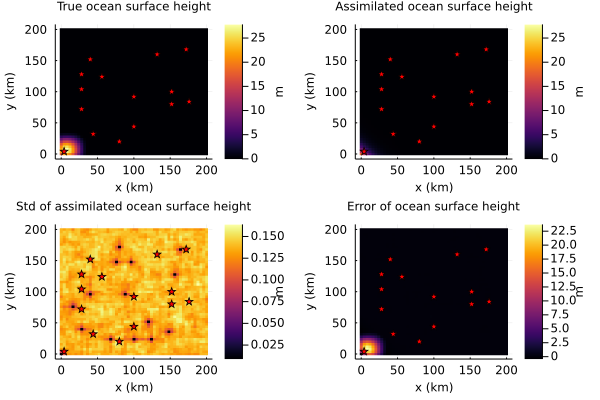

In [164]:
function plot_data(x, y, z_t, z_avg, z_std, field_desc)
    n_contours = 100
    zmax = max(maximum(z_t), maximum(z_avg))
    zmin = min(minimum(z_t), minimum(z_avg))
    levels = range(zmin, zmax; length=n_contours)
    z_err = (z_t-z_avg)
    p1 = heatmap(x, y, z_t; title="True $(lowercase(field_desc))")
    p2 = heatmap(x, y, z_avg; title="Assimilated $(lowercase(field_desc))")
    p3 = heatmap(x, y, z_std; title="Std of assimilated $(lowercase(field_desc))")
    p4 = heatmap(x, y, transpose(z_err); title="Error of $(lowercase(field_desc))")
    for (i, plt) in enumerate((p1, p2, p3, p4))
        # Set labels
        plot!(plt; xlabel="x", ylabel="y")
        # Set range of color bar for first two plots
        i ∈ (1, 2) && plot!(plt; clims=(ustrip(zmin), ustrip(zmax)))
        # Add the positions of the stations
        scatter!(plt, x_st, y_st, color=:red, marker=:star, label="")
    end

    plot(p1, p2, p3, p4; titlefontsize=8, guidefontsize=8)
end

plot_data(x, y, z_t, z_avg, z_std, field_desc)

# Scatter plot of particle weights

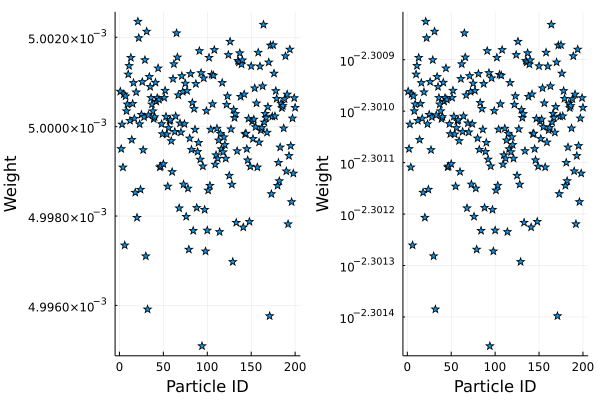

In [165]:
weights = read(fh["weights"][timestamp])

p1 = scatter(weights, marker=:star)
p2 = scatter(weights, marker=:star, yscale=:log10)

for plt in (p1, p2)
    plot!(plt; xlabel="Particle ID", ylabel="Weight")
end

plot(p1, p2, label="")

# Time series of Estimated Sample Size

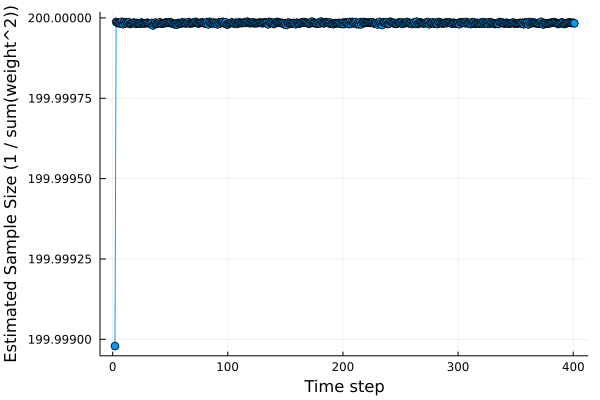

In [166]:
plot([1 / sum(read(w) .^ 2) for w in fh["weights"]];
     label="", marker=:o, xlabel="Time step", ylabel="Estimated Sample Size (1 / sum(weight^2))")

# Animation

In [156]:
animation = @animate for timestamp ∈ keys(fh["data_syn"])
    z_t = read(fh["data_syn"][timestamp][field]) .* uparse(field_unit)
    z_avg = read(fh["data_avg"][timestamp][field]) .* uparse(field_unit)
    z_var = read(fh["data_var"][timestamp][field]) .* uparse(var_unit)
    z_std = sqrt.(z_var)

    plot_data(x, y, z_t, z_avg, z_std, field_desc)
end

mp4(animation, "../results/tsunami/uniform_obs/shelf/nswe_opt.mp4"; fps=1)

┌ Info: Saved animation to 
│   fn = /Users/dangiles/.julia/dev/ParticleDA/results/tsunami/uniform_obs/shelf/nswe_opt.mp4
└ @ Plots /Users/dangiles/.julia/packages/Plots/iYDwd/src/animation.jl:104


Plots.AnimatedGif("/Users/dangiles/.julia/dev/ParticleDA/results/tsunami/uniform_obs/shelf/nswe_opt.mp4")